# LUADLUSC
From HNSC  
* triple sample latent vector recombination  
* balacing subtypes

## Experimental notes

In [ ]:
# Write the line curve object after each replicate run
    # Where?
# Write the front-end box star object after a set of 5 in-memory replicates
    # again, where?

# Big results matrix and full feature engineering appears in bx_crv_itr4.ipynb

In [388]:
from IPython.display import Image

In [3]:
pwd

'/Users/karlberb/Documents/work/sample_count/synthetic_TCGA_data_gen/g_learning_curves'

In [1]:
ls

DAG_smpl_effct_repo.drawio           learning_curve_schematic.drawio.png
DAG_smpl_effct_repo.jpg              learning_curve_schematic_v2.drawio
Few_shot.drawio                      learning_curve_schematic_v2.jpg
Few_shot.drawio.png                  luadlusc.drawio
PDF.ipynb                            luadlusc.drawio.png
Zero_shot.drawio                     luadlusc.png
Zero_shot.drawio.png                 rep_0.0.ipynb
augmented_policy_cloning.jpg         rep_0.1.ipynb
augmented_policy_cloning.svg         rep_0.2.ipynb
box_and_whiskers.ipynb               rep_0.3.ipynb
box_and_whiskers_BRCA.ipynb          rep_0.4.ipynb
box_and_whiskers_LGGGBM.ipynb        rep_0.5.ipynb
box_curve.ipynb                      rep_0.6.ipynb
box_curve_itr1.ipynb                 rep_0.7.ipynb
bx_crv_itr2.ipynb                    rep_0.7_hnsc.ipynb
bx_crv_itr3.ipynb                    rep_0.7_luadlusc.ipynb
bx_crv_itr4.ipynb                    rep_0.7_luadlusc.v2.ipynb
c_latent_sampling.ipynb              sh

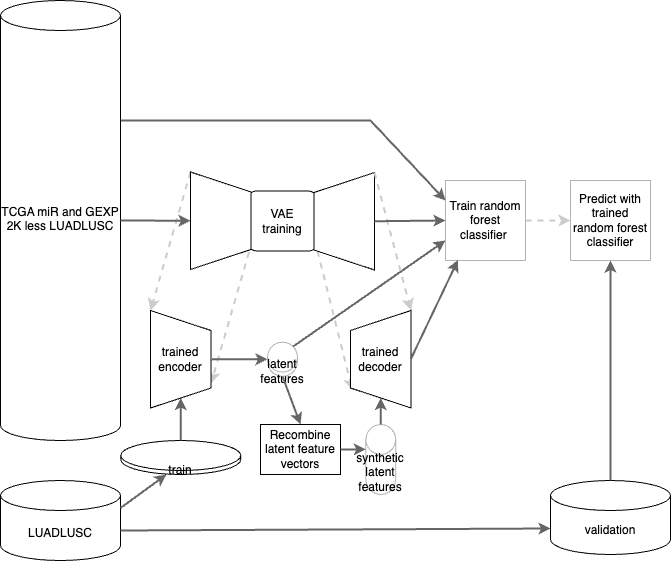

In [391]:
Image(filename='luadlusc.png', width = 500)

In [ ]:
# Latent dim, BRCA curve in v6 was 500
# Feature pruning threshold for mean abs dev (MAD) - currently 5k
# Subsetting on gene expression (GEXP)
# Removal of LGGGGBM
# Batch size, 50 and 10 for pre-train and fine-tune
# All the random forest stuff (like repeats), including the random forest itself
# RF retrain on same trn set returns a different result on the val set
# VAE architechture  - just swap in a transformer
# Retain class imbalance vs. add proportionaly more under-sampled class samples

In [ ]:
# need a reinfocement loop to automate experimental parameter search space

## Version set / Imports

In [1]:
%whos

Interactive namespace is empty.


In [ ]:
# Cold start point, analysis

In [2]:
v = 'rep_0.7' # Primary tumor files within this directory
v

'rep_0.7'

In [ ]:
# HNSC, and LUAD
    # Learning curves
        # Challenge: each learning curve is generated from a single replication split
        # Solution sub-sample a small cancer at ~90% and blend the learning curves
    # Loss plots
    # Front-end box and running average - sig bars failed at replct count < 4
    
    # Take sample count down to 80 - 120 and test on HNSC and LUAD
    # Turn up synthetic sample count by an order of magnitude - done

In [105]:
mkdir i_o/rep_0.7/LUAD

In [106]:
mkdir i_o/rep_0.7/LUAD/decoded_objs

In [107]:
mkdir i_o/rep_0.7/LUAD/front_end_box

In [108]:
mkdir i_o/rep_0.7/LUAD/latent_objs

In [109]:
mkdir i_o/rep_0.7/LUAD/learn_curve

In [110]:
mkdir i_o/rep_0.7/LUAD/loss_plots

In [111]:
mkdir i_o/rep_0.7/LUAD/take-off_points

In [104]:
ls i_o/rep_0.7/

BRCA/     HNSC/     LUADLUSC/


### Imports

In [11]:
import seaborn as sns
import pandas as pd
import glob as glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from statistics import mean
from statistics import stdev
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Activation, Layer
from tensorflow.keras import metrics, optimizers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from matplotlib import rcParams 
from random import sample
from sklearn.metrics import accuracy_score
from statannot import add_stat_annotation

## VAE Setup

In [12]:
# Function set for leave one out loop
def compute_latent(x): # x: This function is argument one in the Lambda layer
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim), mean=0., stddev=1.0 )
    return mu + K.exp(sigma/2)*eps

# Set custom layer , will need all this at start of shell script
class CustomVariationalLayer(Layer):
    """
    Define a custom layer
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

## Feature engineering

### Full molecular input files

In [ ]:
# Combining figure_five_v2.ipynb and bx_crv_itr4.ipynb

In [34]:
from collections import Counter

In [35]:
all_paths = sorted(glob.glob('/Users/karlberb/Documents/work/GDAN_TMP/TMP_v12_20210228/*.tsv'))
cv_folds = (
    glob.glob(
        '/Users/karlberb/Documents/work/GDAN_TMP/TMP_v12_20210228/*CVfolds_5FOLD*.tsv'))
molecular_files = list((Counter(all_paths)-Counter(cv_folds)).elements())

### Get the five datatype prefixes
(from adrenocortical carcinoma)

In [13]:
df = pd.read_csv(
    '/Users/karlberb/Documents/work/GDAN_TMP/TMP_v12_20210228/ACC_v12_20210228.tsv',
    sep="\t", index_col=0)
col_ndx = df.columns[1:]
first_two = []
for i in col_ndx:
    plc_one_two = i.split(':')
    first_two.append(plc_one_two[0] + ':' + plc_one_two[1])
datatype_prefixes = list(set(first_two))

In [14]:
datatype_prefixes

['I:CNVR', 'N:MIR', 'N:METH', 'N:GEXP', 'B:MUTA']

In [15]:
sorted(datatype_prefixes)

['B:MUTA', 'I:CNVR', 'N:GEXP', 'N:METH', 'N:MIR']

In [ ]:
N prefix may be associated with continous datatype

In [ ]:
# All the input and output got stuffed into an "i_o"
# dir at some point to mitigate ridiculous and unnecessary
# gitignore updates

In [ ]:
# Target directories:
    # i_o/MIR                this is just the MIR ripped out of the other datatypes
    # i_o/MIR_intersection   MIR intersection, recall this was already the case, confirm
    # i_o/MIR_etc            (just follow the GEXP pattern, 7 total)

### MIR feature set production

In [32]:
datatype_prefixes[1]

'N:MIR'

In [29]:
pwd

'/Users/karlberb/Documents/work/sample_count/synthetic_TCGA_data_gen/g_learning_curves'

In [30]:
ls i_o

ACC_archive/                     latent feature inspect/
GEXP/                            latent_feature_objects/
GEXP_MAD_5k_across/              learning_curves/
GEXP_MAD_5k_across_no_LGGGBM/    loss_plots/
GEXP_MAD_5k_within/              ops_notes.txt
GEXP_MAD_5k_within_intersection/ rep_0.0/
GEXP_intersection/               rep_0.1/
GEXP_intersection_no_LGGGBM/     rep_0.2/
MSigDB/                          rep_0.3/
PDF_out/                         rep_0.4/
box_curve/                       rep_0.5/
box_whisk/                       rep_0.6/
bx_crv/                          rep_0.7/
bx_crv2/                         shuffle/
bx_crv3/                         six_0.0/
bx_crv4/                         standard_deviation_plots/
decoded/                         untitled.txt
dim10/                           val_0/
dim100_run0/                     val_1/
figure_five/                     val_1.1/
lat_0.0/                         val_1.2/


In [31]:
mkdir i_o/MIR

In [36]:
for pth in molecular_files:
    file = pd.read_csv(pth,
        sep="\t", index_col=0)
    col_ndx = file.columns[1:]
    dtyp_list = [i for i in col_ndx if i.startswith(datatype_prefixes[1])]
    print(file.index.name, len(dtyp_list))
    dtyp_list = ['Labels'] + dtyp_list
    file = file.loc[:, dtyp_list]
    file.to_csv('i_o/MIR/' +
                file.index.name + '_MIR.tsv', sep = '\t')

ACC 743
BLCA 743
BRCA 743
CESC 743
COADREAD 743
ESCC 743
GEA 743
HNSC 743
KIRCKICH 0
KIRP 743
LGGGBM 0
LIHCCHOL 0
LUAD 743
LUSC 743
MESO 743
OV 743
PAAD 743
PCPG 743
PRAD 743
SARC 743
SKCM 743
TGCT 743
THCA 743
THYM 743
UCEC 743
UVM 743


In [50]:
long_list = []
for mir_path in sorted(glob.glob('i_o/MIR/*.tsv')):
    print(mir_path)
    mir_file = pd.read_csv(mir_path, sep ='\t', index_col = 0)
    long_list = long_list + list(mir_file.columns[1:])
# intrsct = set.intersection(*map(set,lol_inline))

i_o/MIR/ACC_MIR.tsv
i_o/MIR/BLCA_MIR.tsv
i_o/MIR/BRCA_MIR.tsv
i_o/MIR/CESC_MIR.tsv
i_o/MIR/COADREAD_MIR.tsv
i_o/MIR/ESCC_MIR.tsv
i_o/MIR/GEA_MIR.tsv
i_o/MIR/HNSC_MIR.tsv
i_o/MIR/KIRCKICH_MIR.tsv
i_o/MIR/KIRP_MIR.tsv
i_o/MIR/LGGGBM_MIR.tsv
i_o/MIR/LIHCCHOL_MIR.tsv
i_o/MIR/LUAD_MIR.tsv
i_o/MIR/LUSC_MIR.tsv
i_o/MIR/MESO_MIR.tsv
i_o/MIR/OV_MIR.tsv
i_o/MIR/PAAD_MIR.tsv
i_o/MIR/PCPG_MIR.tsv
i_o/MIR/PRAD_MIR.tsv
i_o/MIR/SARC_MIR.tsv
i_o/MIR/SKCM_MIR.tsv
i_o/MIR/TGCT_MIR.tsv
i_o/MIR/THCA_MIR.tsv
i_o/MIR/THYM_MIR.tsv
i_o/MIR/UCEC_MIR.tsv
i_o/MIR/UVM_MIR.tsv


In [54]:
type(set(long_list))

set

In [53]:
len(set(long_list))

743

In [ ]:
list(mir_file.columns[1:])

In [43]:
type(lol_inline[0])

pandas.core.indexes.base.Index

## Data

### Read files

In [171]:
file_paths_no_LGGGGBM = sorted(
    glob.glob(
        'i_o/GEXP_MAD_5k_across_no_LGGGBM/*.tsv' # <---- LGGGBM excluded
    ))

In [172]:
%whos

Variable                          Type                      Data/Info
---------------------------------------------------------------------
Activation                        type                      <class 'keras.layers.core.activation.Activation'>
BatchNormalization                type                      <class 'keras.layers.norm<...>tion.BatchNormalization'>
Callback                          type                      <class 'keras.callbacks.Callback'>
Counter                           type                      <class 'collections.Counter'>
CustomVariationalLayer            type                      <class '__main__.CustomVariationalLayer'>
K                                 TFModuleWrapper           <module 'tensorflow.compa<...>ras/backend/__init__.py'>
Layer                             type                      <class 'keras.engine.base_layer.Layer'>
Model                             type                      <class 'keras.engine.training.Model'>
RF_output                        

In [18]:
file_paths_no_LGGGGBM # 11 and 12

['i_o/GEXP_MAD_5k_across_no_LGGGBM/ACC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/BLCA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/BRCA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/CESC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/COADREAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/ESCC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/GEA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/HNSC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRCKICH_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRP_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LIHCCHOL_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LUAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LUSC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/MESO_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/OV_across_5k_no_LGGGBM.tsv',
 '

In [19]:
file_paths_no_LGGGGBM[11] # * luadlusc.v2 start point

'i_o/GEXP_MAD_5k_across_no_LGGGBM/LUAD_across_5k_no_LGGGBM.tsv'

In [21]:
file_paths_no_LGGGGBM[12]

'i_o/GEXP_MAD_5k_across_no_LGGGBM/LUSC_across_5k_no_LGGGBM.tsv'

In [22]:
len(file_paths_no_LGGGGBM)

25

### w/LGGGBM

In [24]:
file_paths = sorted(
    glob.glob(
        'i_o/GEXP_MAD_5k_across/*.tsv' # <---- LGGGBM included
    ))

In [27]:
file_paths[12]

'i_o/GEXP_MAD_5k_across/LUAD_across_5k.tsv'

In [28]:
file_paths[13]

'i_o/GEXP_MAD_5k_across/LUSC_across_5k.tsv'

In [25]:
len(file_paths)

26

### Cohort sample counts

In [ ]:
len_list = []
for path in file_paths:
    file = pd.read_csv(path, sep = '\t', index_col = 0)
    len_list.append((file.index.name, len(file)))

In [10]:
len_list # LUAD 500 as fifth most samples
        # LUSC 460 as seventh most samples

[('ACC', 76),
 ('BLCA', 399),
 ('BRCA', 995),
 ('CESC', 177),
 ('COADREAD', 449),
 ('ESCC', 86),
 ('GEA', 461),
 ('HNSC', 506),
 ('KIRCKICH', 556),
 ('KIRP', 155),
 ('LGGGBM', 782),
 ('LIHCCHOL', 378),
 ('LUAD', 500),
 ('LUSC', 460),
 ('MESO', 74),
 ('OV', 285),
 ('PAAD', 76),
 ('PCPG', 159),
 ('PRAD', 273),
 ('SARC', 191),
 ('SKCM', 444),
 ('TGCT', 133),
 ('THCA', 486),
 ('THYM', 117),
 ('UCEC', 499),
 ('UVM', 74)]

### Pre-train setup

In [6]:
len(file_paths)

26

In [5]:
file_paths

['i_o/GEXP_MAD_5k_across/ACC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/BLCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/BRCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/CESC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/COADREAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/ESCC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/GEA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/HNSC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/KIRCKICH_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/KIRP_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LGGGBM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LIHCCHOL_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LUAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LUSC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/MESO_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/OV_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PAAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PCPG_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PRAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/SARC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/SKCM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across

In [12]:
TCGA_no_BRCA = ['i_o/GEXP_MAD_5k_across/ACC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/BLCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/BRCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/CESC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/COADREAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/ESCC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/GEA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/HNSC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/KIRCKICH_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/KIRP_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LGGGBM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LIHCCHOL_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LUAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LUSC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/MESO_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/OV_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PAAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PCPG_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PRAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/SARC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/SKCM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/TGCT_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/THCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/THYM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/UCEC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/UVM_across_5k.tsv']

### No LGGGBM pre-train setup

In [55]:
file_paths_no_LGGGGBM

['i_o/GEXP_MAD_5k_across_no_LGGGBM/ACC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/BLCA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/BRCA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/CESC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/COADREAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/ESCC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/GEA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/HNSC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRCKICH_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRP_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LIHCCHOL_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LUAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LUSC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/MESO_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/OV_across_5k_no_LGGGBM.tsv',
 '

In [56]:
TCGA_less_LGGGGBM_no_LUAD = ['i_o/GEXP_MAD_5k_across_no_LGGGBM/ACC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/BLCA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/BRCA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/CESC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/COADREAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/ESCC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/GEA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/HNSC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRCKICH_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRP_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LIHCCHOL_across_5k_no_LGGGBM.tsv',
 # 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LUAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LUSC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/MESO_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/OV_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/PAAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/PCPG_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/PRAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/SARC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/SKCM_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/TGCT_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/THCA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/THYM_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/UCEC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/UVM_across_5k_no_LGGGBM.tsv']

### Build an all-but-one TCGA dataframe

In [57]:
tall_stack = pd.DataFrame()
for path in TCGA_less_LGGGGBM_no_LUAD:
    print(path)
    file = pd.read_csv(
    path, sep = '\t', index_col = 0)
    tall_stack = pd.concat( [tall_stack, file] ,
                           axis = 0)

i_o/GEXP_MAD_5k_across_no_LGGGBM/ACC_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/BLCA_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/BRCA_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/CESC_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/COADREAD_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/ESCC_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/GEA_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/HNSC_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRCKICH_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRP_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/LIHCCHOL_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/LUSC_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/MESO_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/OV_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/PAAD_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/PCPG_across_5k_no_LGGGBM.tsv


In [58]:
tall_stack.shape # hold-out all of HNSC from TCGA less LGGGBM

(7509, 5001)

In [24]:
7503-7014

489

In [19]:
tall_stack.shape # hold-out all of BRCA from TCGA less LGGGBM

(7014, 5001)

In [9]:
tall_stack.shape # hold-out all of BRCA w/ LGGGBM

(7796, 5001)

In [20]:
tall_stack.head(1)

,Labels,N:GEXP::ALB:213:,N:GEXP::TG:7038:,N:GEXP::COL1A1:1277:,N:GEXP::FN1:2335:,N:GEXP::KRT5:3852:,N:GEXP::KRT14:3861:,N:GEXP::KRT6A:3853:,N:GEXP::ADAM6:8755:,N:GEXP::SERPINA1:5265:,...,N:GEXP::C14orf1:11161:,N:GEXP::SMCHD1:23347:,N:GEXP::ARL2BP:23568:,N:GEXP::PITPNB:23760:,N:GEXP::KDM5A:5927:,N:GEXP::CNIH:10175:,N:GEXP::ACADS:35:,N:GEXP::YIPF2:78992:,N:GEXP::MEPCE:56257:,N:GEXP::PPARG:5468:
TCGA-OR-A5J1,ACC_2,0.000182,0.360981,0.001892,0.007364,0.0,0.0,0.0,0.000284,0.00609,...,0.246175,0.542221,0.402793,0.335923,0.241655,0.232638,0.13753,0.278195,0.306376,0.078349


In [59]:
pre_train_file = tall_stack

In [60]:
pre_train_file.shape

(7509, 5001)

### Direct / fine-tune

In [61]:
fine_tune_file = pd.read_csv(
    file_paths_no_LGGGGBM[11], # luadlusc are 11-13 depending on LGGGBM drop
    sep = '\t', index_col = 0)
fine_tune_file.index.name

'LUAD'

In [62]:
fine_tune_file

,Labels,N:GEXP::ALB:213:,N:GEXP::TG:7038:,N:GEXP::COL1A1:1277:,N:GEXP::FN1:2335:,N:GEXP::KRT5:3852:,N:GEXP::KRT14:3861:,N:GEXP::KRT6A:3853:,N:GEXP::ADAM6:8755:,N:GEXP::SERPINA1:5265:,...,N:GEXP::C14orf1:11161:,N:GEXP::SMCHD1:23347:,N:GEXP::ARL2BP:23568:,N:GEXP::PITPNB:23760:,N:GEXP::KDM5A:5927:,N:GEXP::CNIH:10175:,N:GEXP::ACADS:35:,N:GEXP::YIPF2:78992:,N:GEXP::MEPCE:56257:,N:GEXP::PPARG:5468:
LUAD,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244,LUAD_3,9.884840e-07,0.002785,0.068996,0.026194,0.000503,0.000016,0.001851,0.006739,0.228309,...,0.258196,0.241991,0.381097,0.201065,0.208198,0.165543,0.371820,0.326699,0.110183,0.109294
TCGA-05-4249,LUAD_1,1.519539e-06,0.014215,0.030964,0.024885,0.000119,0.000005,0.000056,0.069808,0.004767,...,0.234247,0.190006,0.501318,0.281022,0.177769,0.163351,0.359048,0.343708,0.112355,0.018979
TCGA-05-4250,LUAD_3,0.000000e+00,0.001940,0.088737,0.057041,0.001296,0.001128,0.116079,0.014534,0.046387,...,0.240438,0.128370,0.517532,0.318290,0.141373,0.255219,0.186300,0.238281,0.130820,0.056747
TCGA-05-4382,LUAD_4,6.437795e-05,0.007256,0.083627,0.139674,0.000001,0.000178,0.000735,0.173953,0.008338,...,0.569459,0.181108,0.433615,0.280626,0.224534,0.182698,0.212245,0.177695,0.088596,0.082127
TCGA-05-4384,LUAD_1,0.000000e+00,0.000325,0.012121,0.042306,0.000040,0.000000,0.001355,0.020755,0.035569,...,0.267288,0.206566,0.378803,0.271437,0.229935,0.119614,0.255944,0.145357,0.140562,0.044493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-NJ-A55O,LUAD_1,0.000000e+00,0.003414,0.009071,0.012267,0.000022,0.000000,0.000157,0.029058,0.016759,...,0.328335,0.157729,0.260720,0.252315,0.277642,0.124029,0.245952,0.326509,0.150533,0.050598
TCGA-NJ-A55R,LUAD_2,1.134038e-05,0.021985,0.074417,0.031651,0.000023,0.000066,0.000086,0.123833,0.040466,...,0.349581,0.191583,0.259162,0.243986,0.201017,0.119988,0.322370,0.248814,0.188929,0.006229
TCGA-NJ-A7XG,LUAD_1,1.433830e-03,0.000244,0.010931,0.004520,0.000375,0.001677,0.008944,0.006753,0.111460,...,0.192213,0.119453,0.406987,0.251082,0.167088,0.072831,0.250536,0.327102,0.180222,0.038724


In [63]:
fine_tune_file.Labels.value_counts()

LUAD_1    174
LUAD_2    143
LUAD_3    104
LUAD_4     43
LUAD_5     36
Name: Labels, dtype: int64

In [64]:
fine_tune_file.index.name

'LUAD'

### MSigDB setup

In [ ]:
# c2 is curated gene sets
# c4 is computational gene sets
# c6 is oncogenic gene sets
# c8 is cell type (is this interesting given the bulk sequencing nature of the expression data

#### MSigDB devel

In [55]:
with open('i_o/MSigDB/c2.all.v2022.1.Hs.symbols.gmt.txt') as gmt:
    print(gmt.read(3000))

SHARMA_ASTROCYTOMA_WITH_NF1_SYNDROM	http://www.gsea-msigdb.org/gsea/msigdb/human/geneset/SHARMA_ASTROCYTOMA_WITH_NF1_SYNDROM	ADGRV1	MAP3K7CL	CLEC3B	SLC1A3	STN1
LIU_OVARIAN_CANCER_TUMORS_AND_XENOGRAFTS_XDGS_UP	http://www.gsea-msigdb.org/gsea/msigdb/human/geneset/LIU_OVARIAN_CANCER_TUMORS_AND_XENOGRAFTS_XDGS_UP	RPLP0P11	PFN1P11	DSCAM-AS1	MT-TS2	FGB	MT-TL2	PAX2	FOXB1	MAGEC2	SLC28A2	LINC02593	CPLX2	MGAT5B	SBK2	LEMD1-DT	ANK1	EVPLL	TGM7	LCN10	ENSG00000262884	DISP3	SIAH3	IGSF23	RD3	MYOM3	MIR4664	NAT8L	ALPL	LINC01001	FOXI3	KCNH3	GRIN2B	XKR7	CELSR3	CICP27	RASSF10	LINC02108	SKIDA1	STAG3L3	FAR2P1	LINC01224	ID1	WDR62	CCDC150	PLEKHG4B	RBM25-AS1	STAG3L5P	KIF18B	ZDHHC8P1	DDX12P	MKRN3	GOLGA2P5	TUBA5P	ZNF114	LINC00319	MYBL2	UCA1	KSR2	CYSRT1	MIR1302-9HG	HASPIN	MKI67	CNGB1	MIR29B2CHG	GGT2P	CCNF	SNORD86	LY6G5B	FBN3	DUX4L27	RNFT2	ULBP3	MAP3K9	LINC01873	LINC01764	LINC00958	TROAP	PALM3	PIF1	OCLNP1	P2RY2	GPAT4-AS1	RAP1GAP2	ENSG00000260874	KIF12	PAX8-AS1	FAM215B	MT-TH	PROX2	CLSPN	LHX4	SULT1A3	DACT2	GPC1-AS1	LI

In [57]:
!pip3 install gsea_api

  Preparing metadata (setup.py) ... done
  Created wheel for gsea_api: filename=gsea_api-0.3.4-py3-none-any.whl size=16222 sha256=30b329bf5aefd824a4c97e0302b9a1d8a68920c5ef139cb7c2a9a82a3e3fede1
  Stored in directory: /Users/karlberb/Library/Caches/pip/wheels/56/15/35/fba801a64dbbeffa992988de38bcc17e110862d467a07136e1
Successfully built gsea_api


In [58]:
from gsea_api.molecular_signatures_db import GeneSets

In [72]:
!pip3 install gseapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.1/444.1 kB 7.8 MB/s eta 0:00:0000:01


In [73]:
import gseapy as gp

In [75]:
hlmrk = gp.read_gmt(path="i_o/MSigDB/c2.all.v2022.1.Hs.symbols.gmt")

In [ ]:
hlmrk.keys()

In [77]:
len(hlmrk)

6449

In [ ]:
pd.DataFrame(hlmrk)

## Validation setup

#### Stats

In [65]:
len (fine_tune_file) / 2

250.0

In [66]:
len (fine_tune_file)

500

In [67]:
len (fine_tune_file) * .25 # 25%

125.0

In [78]:
40/500

0.08

In [79]:
36/500

0.072

In [81]:
36*.072

2.5919999999999996

In [91]:
43/500

0.086

In [92]:
36*.086

3.0959999999999996

In [ ]:
# Expected frequency of sampling

In [ ]:
# 2022-01-05 check for 3 minimum samples in each subtype
# Disproportionally boost the undersampled subtypes - done

#### Replicates split

In [76]:
fine_tune_file.Labels.value_counts()

LUAD_1    174
LUAD_2    143
LUAD_3    104
LUAD_4     43
LUAD_5     36
Name: Labels, dtype: int64

In [ ]:
# 74 samples in Mesothelioma and UVN

In [ ]:
# note, 2022-01-08 running at 74 samples to get a feel for generalizing to smaller cancers

In [175]:
trn_size = 74 # End point of real data in learning curve
trn_size

74

In [179]:
inpt_val = pd.DataFrame() # blue
lat_val = pd.DataFrame() # Turning this back on, red
dec_val = pd.DataFrame() # green
synth_lat_val = pd.DataFrame() # dark orange
synth_inpt_val = pd.DataFrame() # light orange
blend_inpt_synthFrmLat_val = pd.DataFrame() # dotted blue and orange

In [ ]:
del(tall_stack)
del(file)

In [37]:
# Two training files and five replicate results storage objects:

In [40]:
%whos DataFrame

Variable                     Type         Data/Info
---------------------------------------------------
blend_inpt_synthFrmLat_val   DataFrame    Empty DataFrame\nColumns: []\nIndex: []
dec_val                      DataFrame    Empty DataFrame\nColumns: []\nIndex: []
fine_tune_file               DataFrame                  Labels  N:G<...>[506 rows x 5001 columns]
inpt_val                     DataFrame    Empty DataFrame\nColumns: []\nIndex: []
lat_val                      DataFrame    Empty DataFrame\nColumns: []\nIndex: []
pre_train_file               DataFrame                 Labels  N:GE<...>7503 rows x 5001 columns]
synth_inpt_val               DataFrame    Empty DataFrame\nColumns: []\nIndex: []
synth_lat_val                DataFrame    Empty DataFrame\nColumns: []\nIndex: []


In [71]:
repeats = 10 # to all random forest validation runs

## Start Replicate run here <---  
toggle the validation split code

In [174]:
v # Check where all this stuff is gonna go

'rep_0.7'

In [380]:
val_split = 'vs05@'+str(trn_size) # Replicates TOGGLE <--- start at one
trn = fine_tune_file.sample(trn_size) # Build train and validation files from fine-tune
val = fine_tune_file.loc[fine_tune_file[~fine_tune_file.index.isin(trn.index)].index, :]
val_split

'vs05@74'

In [381]:
trn.shape

(74, 5001)

In [382]:
trn.Labels.value_counts()

LUAD_1    26
LUAD_3    18
LUAD_2    17
LUAD_5     8
LUAD_4     5
Name: Labels, dtype: int64

In [383]:
if trn.Labels.value_counts().min() < 3:
    print('Undersampled subtype')
else:
    print('Good to go, minimum sample count is',trn.Labels.value_counts().min())

Good to go, minimum sample count is 5


## <font color='blue'>Input</font> validation plot

In [184]:
pretrain_status = '_TCGA_'+number_of_training_epic_here+'_epochs'

NameError: name 'number_of_training_epic_here' is not defined

In [384]:
print('Start input validation with RF')
val_inpt_acrcy_lst = []
val_inpt_running_average = []

X_trn = trn.iloc[:, 1:] # Train objects for RF
y_trn = trn.iloc[:, 0]
X_val = val.iloc[:, 1:] # Validation objects, checked above
y_val = val.iloc[:, 0]

for r in list(range(0, repeats)): # pre-set, to be re-used for all take-off points
    if r == 5:
        print('Half way to 10 rpts')    
    
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn) # Do not fit on val data
    val_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val)) # <--- predict on validation set, important
    val_inpt_acrcy_lst.append(val_raw_acc) # Box plots
    val_inpt_running_average.append(mean(val_inpt_acrcy_lst))
inpt_val.insert(0, val_split, val_inpt_running_average)
print('Input transfer predictions complete')

Start input validation with RF
Half way to 10 rpts
Input transfer predictions complete


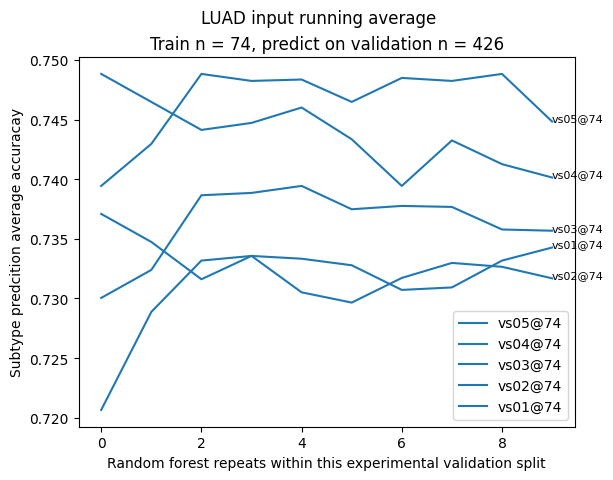

In [385]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
    plt.annotate(run, (9, inpt_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' input running average')
plt.title('Train n = '+str(
    len(trn))+', predict on validation n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.legend()
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

### Box setup

In [320]:
inpt_val.iloc[repeats-1, :] # final row is most-updated average

vs05@40     0.495279
vs04@50     0.621491
vs03@60     0.716816
vs02@75     0.703712
vs01@100    0.657143
Name: 9, dtype: float64

In [321]:
v

'rep_0.7'

In [173]:
trn.index.name

'LUAD'

In [322]:
val_split

'vs05@40'

In [132]:
val_split

'vs02@75'

In [ ]:
# Send to front-end box after fifth replicate, really is a post-hoc summary
# of front-end parameters sent to the line curve set

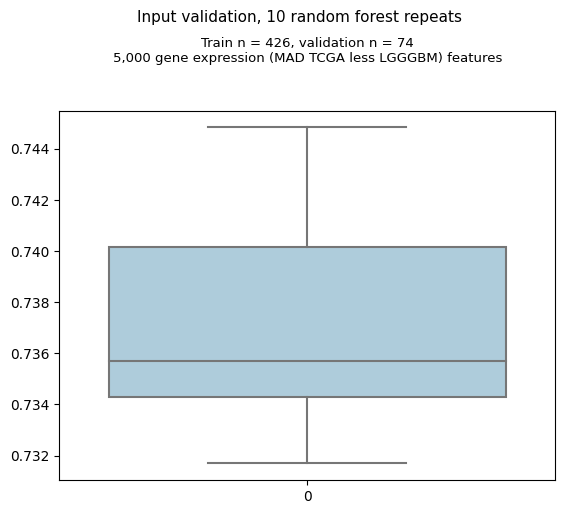

In [386]:
ax = sns.boxplot(inpt_val.iloc[9, :], # Most-updated average goes here
                 palette = [plt.cm.Paired(0)])
plt.suptitle('Input validation, '+str(repeats)+' random forest repeats',
             fontsize = 11, y = 1.09)
plt.title('Train n = '+str(
    len(val))+', validation n = '+str(
    len(trn))+'\n5,000 gene expression (MAD TCGA less LGGGBM) features',
          fontsize = 9.5, y = 1.11)

# add_stat_annotation(ax,
#                     data=input_val_frame,
#                     # x=x, y=y, order=order,
#                     box_pairs=[('Hold_in_raw_accuracy', 'Hold_out_raw_accuracy')],
#                     test='Mann-Whitney', text_format='star', loc='outside', verbose=0)

plt.savefig(
    'i_o/'+v+'/'+trn.index.name+'/front_end_box/input_val_'+str(trn_size)+'_'+val_split+'.png', bbox_inches = 'tight')

## VAE training

In [ ]:
# Train and direct decode

train_object = trn   # <---- *** Do not train the VAE ever on hold-out; encode with pre-trained? - yes
fit_on_plot_title = train_object.index.name + ' n = ' + str(len(trn))
fit_on_file_write = train_object.index.name + '_n_'+ str(len(trn))

pre_trn = 'NONE'
feature_set = 'mad_5k_acros_no_LGGGBM'

pre_train_epochs = 'NA'
fine_tune_epochs = 'NA'

features = train_object.columns[1:]

original_dim = len(features)
feature_dim = len(features)
latent_dim = 100 # Direct train and decode (no need to match between pre-train and fine-tune)

encoder_inputs = keras.Input(shape=(feature_dim,))
z_mean_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_1")(encoder_inputs)
z_mean_dense_batchnorm = layers.BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = layers.Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_2")(encoder_inputs)
z_log_var_dense_batchnorm = layers.BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = layers.Activation('relu')(z_log_var_dense_batchnorm)

latent_space = layers.Lambda(compute_latent, output_shape=(latent_dim,), name="latent_space")([z_mean_encoded, z_log_var_encoded])

decoder_to_reconstruct = layers.Dense(feature_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
decoder_outputs = decoder_to_reconstruct(latent_space)

learning_rate = 0.0005
kappa = 1

beta = K.variable(0)

adam = optimizers.Adam(learning_rate=learning_rate)
vae_layer = CustomVariationalLayer()([encoder_inputs, decoder_outputs])
vae = Model(encoder_inputs, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

train_epochs = 200

fit_start = time.time()
history = vae.fit(train_object.iloc[:, 1:],
            epochs=train_epochs,
                  batch_size=50,
                  shuffle=True,
                  callbacks=[WarmUpCallback(beta, kappa)],
                  verbose=0
                  )
fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss",linewidth = 10)

plt.title(fit_on_plot_title+' train', fontsize = 32
         )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate(str(train_epochs)+' epochs'+
             '\n'+str(latent_dim)+' latent',
            xy = (.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 32
            )

plt.savefig(
    'i_o/'+v+'/fit.'+fit_on_file_write+'.epochs.'+str(train_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+fine_tune_epochs+
    '_latent_dim.'+str(latent_dim)+'_'+
    feature_set+'_'+val_split+
    '.png', bbox_inches='tight')

encoder = Model(encoder_inputs, z_mean_encoded)
decoder_input = keras.Input(shape = (latent_dim, ))
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

y_df = train_object.Labels

decoded = pd.DataFrame(decoder.predict(encoder.predict(train_object.iloc[:, 1:])),
                       index = train_object.index, columns = train_object.iloc[:, 1:].columns)

latent_object = pd.DataFrame(encoder.predict(train_object.iloc[:, 1:]),
             index=train_object.index,
        )
latent_object.index.name = train_object.index.name
latent_object = pd.concat( [pd.DataFrame(y_df), latent_object] , axis =1)
latent_object.to_csv(
    'i_o/'+v+'/fit.'+fit_on_file_write+'.epochs.'+str(train_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+str(pre_train_epochs)+
    '_latent_object_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+val_split+
    '.tsv',
    sep = '\t')

decoded_labeled = pd.concat( [pd.DataFrame(y_df), decoded] , axis =1)
decoded_labeled.to_csv(
    'i_o/'+v+'/fit.'+fit_on_file_write+'.epochs.'+str(train_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+str(pre_train_epochs)+
    '_decoded_obj_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+val_split+
    '.tsv',
    sep = '\t')

print('Train and decode with '+feature_set+' feature set experiment done')

## VAE Pre train and fine-tune

2023-01-09 13:35:37.816795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 13:35:37.894469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 13:35:37.988719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 13:35:38.205389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 13:35:38.287497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 13:35:38.338600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 13:35:41.475356: I tensorflow/core/grappler/optimizers/cust

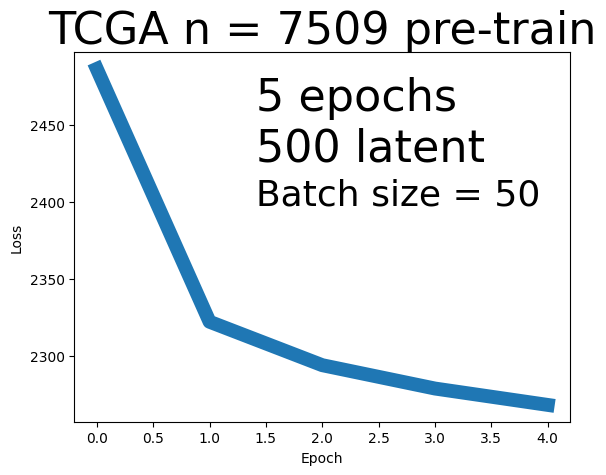

In [387]:
# Pre-train fitting with MAD 5k taken across all cancers

train_file = pre_train_file
fit_on_plot_title = 'TCGA n = ' + str(len(pre_train_file))
fit_on_file_write = 'TCGA_n_'+ str(len(pre_train_file))
pre_trn = 'NONE'
feature_set = 'mad_5k_across'

fine_tune_epochs = 'NA'

features = train_file.columns[1:] # Train file toggled above

original_dim = len(features)
feature_dim = len(features)
latent_dim = 500               # Toggle to plot labels <--- Latent feature set diminsionality       *******
batch_size = 50

encoder_inputs = keras.Input(shape=(feature_dim,))
z_mean_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_1")(encoder_inputs)
z_mean_dense_batchnorm = layers.BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = layers.Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_2")(encoder_inputs)
z_log_var_dense_batchnorm = layers.BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = layers.Activation('relu')(z_log_var_dense_batchnorm)

latent_space = layers.Lambda(compute_latent, output_shape=(latent_dim,), name="latent_space")([z_mean_encoded, z_log_var_encoded])

decoder_to_reconstruct = layers.Dense(feature_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
decoder_outputs = decoder_to_reconstruct(latent_space)

learning_rate = 0.0005 # test this

kappa = 1
beta = K.variable(0)

adam = optimizers.Adam(learning_rate=learning_rate)
vae_layer = CustomVariationalLayer()([encoder_inputs, decoder_outputs])
vae = Model(encoder_inputs, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta]) # Take-off point from pre-training to fine-tuning

pre_train_epochs = 5

fit_start = time.time()
history = vae.fit(train_file.iloc[:, 1:],  #  fit the VAE on object, toggled in the setup
            epochs=pre_train_epochs,
                  batch_size=batch_size,
                  shuffle=True,
                  callbacks=[WarmUpCallback(beta, kappa)],
                  verbose=0 #  <---------------------- turn this on for production *************
                  )
fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss",linewidth = 10)

plt.title(fit_on_plot_title+' pre-train', fontsize = 32
         )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate(str(pre_train_epochs)+' epochs'+
             '\n'+str(latent_dim)+' latent',
            xy = (.4, .83), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 32
            )
plt.annotate('Batch size = '+str(batch_size),        
            xy = (.4, .62), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 26
            )
# plt.legend(loc="lower left")
plt.savefig(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/loss_plots/fit.'+fit_on_file_write+'_epochs.'+str(pre_train_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+fine_tune_epochs+
    '_latent_dim.'+str(latent_dim)+'_'+ # Do not change latent dim in the middle of transfer training
    # '_pltv-'+str(plt_v)+
    # 'fitting_epochs.'+str(epochs)+'_'+
    feature_set+'_'+val_split+
    '.png', bbox_inches='tight')

/Users/karlberb/miniforge3/envs/tf_M1_py3dot9/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-01-09 13:36:53.337411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 13:36:53.467390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Fine tuning with mad_5k_across feature set experiment done


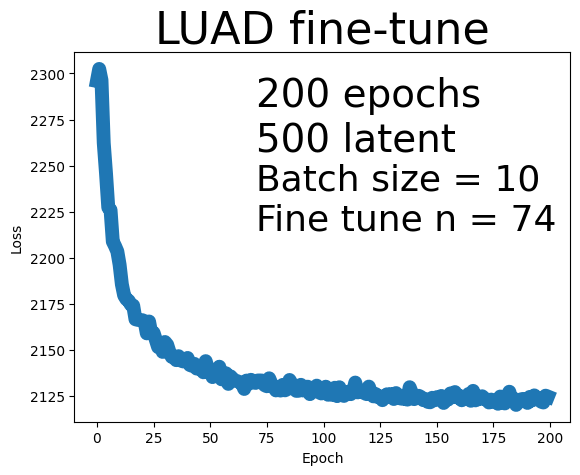

In [388]:
# Fine-tuning
# pretrain epochs variable in memory from above, latent dim also set already at this point

train_file = trn
pre_trn = fit_on_file_write
fit_on = trn.index.name

fine_tune_epochs = 200 # Overwrite 'NA' for this variable, from above; fine-tuning easy: 100, hard: 200
batch_size = 10

fit_start = time.time()
history = vae.fit(train_file.iloc[:, 1:],  #  fit the VAE on object, toggled in the setup
            epochs = fine_tune_epochs, batch_size=batch_size, shuffle=True,
            callbacks = [WarmUpCallback(beta, kappa)],
                 verbose=0 #  <---------------------- turn this on for production *************
                 )

fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss",linewidth = 10)

plt.title(fit_on+' fine-tune', fontsize = 32
         )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate(str(fine_tune_epochs)+' epochs'+
            '\n'+str(latent_dim)+' latent',     
            xy = (.4, .83), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 28
            )
plt.annotate('Batch size = '+str(batch_size)+
            '\nFine tune n = '+str(trn.shape[0]),             
            xy = (.4, .65), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 26
            )

# plt.legend(loc="lower left")
plt.savefig(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/loss_plots/fit.'+fit_on+'_epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+str(pre_train_epochs)+
    '_latent_dim.'+str(latent_dim)+'_'+ # Do not change latent dim in the middle of transfer training
    # '_pltv-'+str(plt_v)+
    # 'fitting_epochs.'+str(epochs)+'_'+
    feature_set+'_'+val_split+
    '.png', bbox_inches='tight') # version 18, norm within cohort
# plt.close()

encoder = Model(encoder_inputs, z_mean_encoded)
decoder_input = keras.Input(shape = (latent_dim, ))
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

y_df = train_file.Labels

decoded = pd.DataFrame(decoder.predict(encoder.predict(train_file.iloc[:, 1:])), # rep v.7 checks, run the training samples throught the model
                       index = train_file.index, columns = train_file.iloc[:, 1:].columns)

latent_object = pd.DataFrame(encoder.predict(train_file.iloc[:, 1:]),
             index=train_file.index,
                # columns=decode_df.iloc[:, 1:].columns # Columns are different because this is latent space
        )
latent_object.index.name = trn.index.name
latent_object = pd.concat( [pd.DataFrame(y_df), latent_object] , axis =1)
latent_object.to_csv(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/latent_objs/fit.'+fit_on+'_epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+str(pre_train_epochs)+
    '_latent_obj_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+val_split+
    '.tsv',
    sep = '\t')
# break
decoded_labeled = pd.concat( [pd.DataFrame(y_df), decoded] , axis =1)
decoded_labeled.to_csv(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/decoded_objs/fit.'+fit_on+'_epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+str(pre_train_epochs)+
    '_decoded_obj_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+val_split+
    '.tsv',
    sep = '\t')

print('Fine tuning with '+feature_set+' feature set experiment done')

In [ ]:
# Observations: LUAD looks like 125 or so might be good ( at 50 samples )
# pretty flat by 150 epochs running at 74 samples
# split 2 at 74 also looks pretty flat by 150 epochs, starting list of pararmeter tuning priorities

## <font color='red'>Latent</font> plus <font color='blue'>input</font> validation plot
Red curve on plot, keep for explaining how the synthetic latent curve is derived

In [ ]:
# Get the encoder
    # Held-out validation set must have same feature space to run a test on
    # This means a train-set trained encoder is required

In [ ]:
# Encoder in memory trained on trn set

In [115]:
val.shape#replicate one

(450, 5001)

In [116]:
val.shape # Rep two

(450, 5001)

In [117]:
val.shape # R three

(450, 5001)

In [389]:
val_encoded = pd.DataFrame(encoder.predict( # Sample count does not match here, this is the whole point
    val.iloc[:, 1:]),
        index = val.index)
val_encoded_labeled = pd.concat(
    [pd.DataFrame(val.Labels),
     val_encoded] , axis =1)

In [119]:
val_encoded_labeled.shape # predict on with random forest

(450, 501)

In [390]:
# Latent to random forest
print('Latent validation start')
X_trn = latent_object.iloc[:, 1:] # Now train on dimensionally reduced latent feature set, is latent_obj written out? A: yes
y_trn = latent_object.iloc[:, 0]
X_val = val_encoded_labeled.iloc[:, 1:] # Predict on the held-out validation set dimensionally reduced with the trained encoder
y_val = val_encoded_labeled.iloc[:, 0] 
val_lat_raw_acc_lst = []
val_lat_running_average = []
for r in list(range(0, repeats)): # pre-set, to be re-used for all take-off points
    if r == 5:
        print('five done')   
    
    clf_trn = RandomForestClassifier() # Leave in loop to reinitialie each time through
    clf_trn.fit(X_trn, y_trn)
    val_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    val_lat_raw_acc_lst.append(val_raw_acc) # Box plots
    val_lat_running_average.append(mean(val_lat_raw_acc_lst))
lat_val.insert(0, val_split, val_lat_running_average)
print('Latent validation complete')

Latent validation start
five done
Latent validation complete


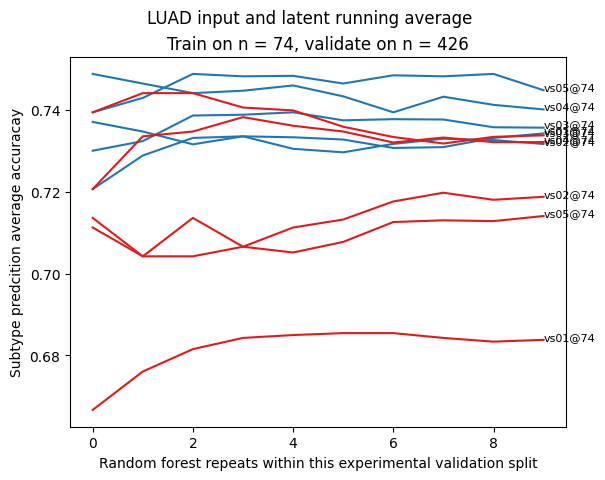

In [391]:
# Latent vs. input front-end plot, zoom in on running average withing each experimental replicate, eventually summarize with front-end box
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
    plt.annotate(run, (9, inpt_val[run][9]), fontsize = 8)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = plt.cm.Paired(5), label = run)
    plt.annotate(run, (9, lat_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' input and latent running average')
plt.title('Train on n = '+str(
    len(trn))+', validate on n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
# plt.legend()
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input+latent_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

## Decoded plus latent and input validation plot

In [122]:
decoded_labeled.shape

(50, 5001)

In [123]:
val.shape

(450, 5001)

In [392]:
# Validate with train on decoded
print('Decoded validation start')
X_trn = decoded_labeled.iloc[:, 1:] # Train on full set of decoded samples that were used to train the VAE
y_trn = decoded_labeled.iloc[:, 0]
X_val = val.iloc[:, 1:]             # Predict on validation
y_val = val.iloc[:, 0]   

val_dec_raw_acc_lst = []
val_dec_running_average = []

for r in list(range(0, repeats)): # pre-set, to be re-used for all take-off points
    if r == 5:
        print('half done') 
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn)
    val_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    val_dec_raw_acc_lst.append(val_raw_acc) # Box plots
    val_dec_running_average.append(mean(val_dec_raw_acc_lst))
dec_val.insert(0, val_split, val_dec_running_average)
print('Decoded validation complete')

Decoded validation start
half done
Decoded validation complete


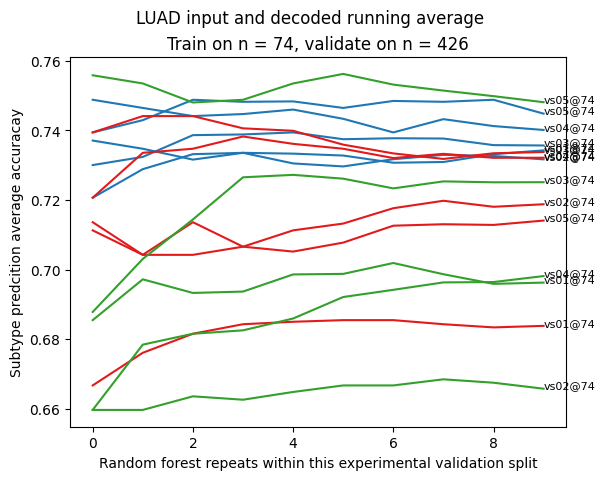

In [393]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
    plt.annotate(run, (9, inpt_val[run][9]), fontsize = 8)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = plt.cm.Paired(5), label = run)
    plt.annotate(run, (9, lat_val[run][9]), fontsize = 8)
for run in dec_val.columns:
    plt.plot(dec_val[run], color = plt.cm.Paired(3), label = run)
    plt.annotate(run, (9, dec_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' input and decoded running average')
plt.title('Train on n = '+str(
    len(trn))+', validate on n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input+latent+decoded_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

## Synth main
Sythesize on latent and send to decoder  
Then train-on this decoded synth lat set and finally predict validation set that has not gone to VAE at all.

In [126]:
latent_object.shape

(50, 501)

In [127]:
subtype_count_3_sample_rejection_list = []

In [128]:
trn.Labels.value_counts().min() # Check the validation split for minimum three samples
# * track the rejection rate

3

In [129]:
trn.Labels.value_counts().max() # apply max sample count to each subtype

18

In [ ]:
# Go back and add the batch size to the pre-training loss plot
# Print the individual sample counts on the fine-tuning plot

In [ ]:
# Experimental objective:
    # Run 10 replicates:
        # 5 replicates with resampling (minimum) three samples per synthetic sample
            # Rep one - boosted at 100 samples
            # Rep two - reduced to 75 samples - 
            # 
        # 5 replicates with resampling entire feature vector per synthetic sample

In [ ]:
# Alternate methods to set samples size:
    # Percentage of validation split (?)
    #

In [394]:
# Three samples per synthetic sample generated
print('Starting', val_split, 'synth gen from latent')
synth_in_count = 3
synth_sub_len = 100

synth_ndx_strt = 0
synth_full_frame = pd.DataFrame(columns = latent_object.columns)

for subtype in sorted(latent_object.Labels.unique()):  
    print(subtype)
    sub = latent_object[latent_object.Labels == subtype]
    print(synth_sub_len)
    synth_index = ['SYNTH-' + fine_tune_file.index.name + '-' + jtem for jtem in [str(
        item).zfill(5) for item in list(range(synth_ndx_strt,
                                              synth_sub_len + synth_ndx_strt))]]
    synth_sub_frame = pd.DataFrame(index = synth_index)
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])
    
    synth_dict = {}
    for synth_sample in synth_sub_frame.index:
        input_sample_set = sub.sample(synth_in_count)
        new_samp_vec = []
        for col in input_sample_set.iloc[:, 1:]:
            vals_inpt = input_sample_set.loc[:, col]
            choosen_val = vals_inpt.sample(1)
            new_samp_vec.append(choosen_val.values[0])

        synth_dict[synth_sample] = new_samp_vec
    synth_sub_frame = pd.concat([synth_sub_frame, pd.DataFrame(synth_dict).T], axis = 1)

    synth_full_frame = pd.concat(
        [synth_full_frame, synth_sub_frame], axis = 0) 
    
    synth_ndx_strt = synth_ndx_strt + synth_sub_len
print('Synth from latent, '+str(synth_sub_len)+' samples for each subtype')

Starting vs05@74 synth gen from latent
LUAD_1
100
LUAD_2
100
LUAD_3
100
LUAD_4
100
LUAD_5
100
Synth from latent, 100 samples for each subtype


### Decode synthetic generated from latent

In [395]:
synth_lat_dec = pd.concat([synth_full_frame.iloc[:, 0],
                       pd.DataFrame(decoder.predict(synth_full_frame.iloc[:, 1:]), index = synth_full_frame.index)],
                     axis = 1)
synth_lat_dec.columns = trn.columns

In [253]:
synth_lat_dec.Labels.value_counts() # carry sub len var to inpt smpl gen

LUAD_1    100
LUAD_2    100
LUAD_3    100
LUAD_4    100
LUAD_5    100
Name: Labels, dtype: int64

In [396]:
# Validate synthetic: train on synthetic latent decoded, predict on validation

print('Synth latent validation start')
X_trn = synth_lat_dec.iloc[:, 1:] # Train on decoded synthetic latent
y_trn = synth_lat_dec.iloc[:, 0]
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]   

synth_lat_raw_acc_lst = []
synth_lat_running_average = []

for r in list(range(0, repeats)): # pre-set, to be re-used for all take-off points
    if r == 5:
        print('half')
    
    clf_trn = RandomForestClassifier() # Initialize classifier
    clf_trn.fit(X_trn, y_trn)
    synth_lat_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    synth_lat_raw_acc_lst.append(synth_lat_raw_acc) # Box plots
    synth_lat_running_average.append(mean(synth_lat_raw_acc_lst))
synth_lat_val.insert(0, val_split, synth_lat_running_average)
print('Synth latent complete')

Synth latent validation start
half
Synth latent complete


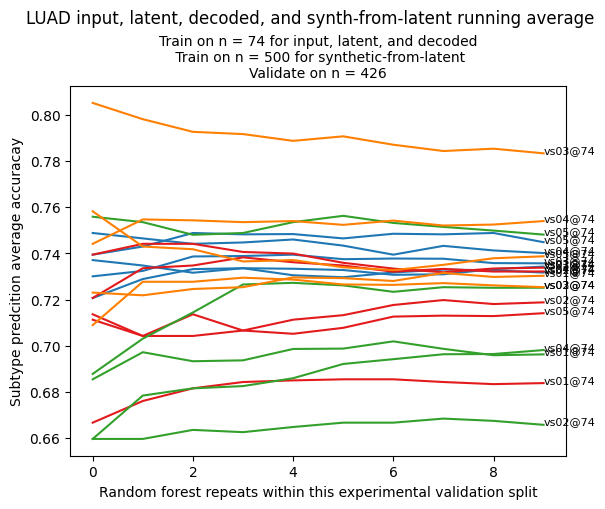

In [397]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
    plt.annotate(run, (9, inpt_val[run][9]), fontsize = 8)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = plt.cm.Paired(5), label = run)
    plt.annotate(run, (9, lat_val[run][9]), fontsize = 8)
for run in dec_val.columns:
    plt.plot(dec_val[run], color = plt.cm.Paired(3), label = run)
    plt.annotate(run, (9, dec_val[run][9]), fontsize = 8)
for run in synth_lat_val.columns:
    plt.plot(synth_lat_val[run], color = plt.cm.Paired(7), label = run)
    plt.annotate(run, (9, synth_lat_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' input, latent, decoded, and synth-from-latent running average',
            y = 1.04)
plt.title('Train on n = '+str(
    len(trn))+' for input, latent, and decoded'+
          '\n Train on n = '+str(len(synth_lat_dec))+' for synthetic-from-latent'
          '\nValidate on n = '+str(
    len(val)), size = 10)
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input+latent+decoded+synthLat_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

## Synthetic input - triples

In [398]:
print('Starting', val_split, 'synth gen from input')
synth_ndx_strt = 0
synth_inpt_frame = pd.DataFrame(columns = latent_object.columns)
# synth_sub_len = 100 # Set in the latent sample generator, retain here
for subtype in sorted(trn.Labels.unique()):
    start = time.time()
    print(subtype)
    sub = trn[trn.Labels == subtype]
    print(synth_sub_len)
    synth_index = ['SYNTH-' + fine_tune_file.index.name + '-' + jtem for jtem in [str(
        item).zfill(5) for item in list(range(synth_ndx_strt,
                                              synth_sub_len + synth_ndx_strt))]]
    synth_sub_frame = pd.DataFrame(index = synth_index)
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])
    
    synth_dict = {}
    for synth_sample in synth_sub_frame.index:
        trpl = sub.sample(3)
        new_samp_vec = []
        for col in trpl.iloc[:, 1:]:
            vals_inpt = trpl.loc[:, col]
            choosen_val = vals_inpt.sample(1)
            new_samp_vec.append(choosen_val.values[0])

        synth_dict[synth_sample] = new_samp_vec
    synth_sub_frame = pd.concat([synth_sub_frame, pd.DataFrame(synth_dict).T], axis = 1)

    synth_inpt_frame = pd.concat(
        [synth_inpt_frame, synth_sub_frame], axis = 0) 
    
    synth_ndx_strt = synth_ndx_strt + synth_sub_len
    print('loop time: ', round(time.time() - start, 2))
print('Synth from input done, '+str(synth_sub_len)+' samples for each subtype')

Starting vs05@74 synth gen from input
LUAD_1
100
loop time:  23.83
LUAD_2
100
loop time:  23.11
LUAD_3
100
loop time:  23.14
LUAD_4
100
loop time:  23.13
LUAD_5
100
loop time:  22.97
Synth from input done, 100 samples for each subtype


In [136]:
synth_inpt_frame.Labels.value_counts()

LUAD_1    100
LUAD_2    100
LUAD_3    100
LUAD_4    100
LUAD_5    100
Name: Labels, dtype: int64

#### automate subtype count print on figures

In [156]:
type(synth_inpt_frame.Labels.value_counts())

pandas.core.series.Series

In [157]:
synth_inpt_frame.Labels.value_counts()[0]

100

In [162]:
synth_inpt_frame.Labels.value_counts().index[0]

'HNSC_1'

In [ ]:
# end auto subtype count devel (for plot labels ?)

In [399]:
synth_input_decoded = pd.DataFrame(decoder.predict(encoder.predict(synth_inpt_frame.iloc[:, 1:])),
                       index = synth_inpt_frame.index, columns = synth_inpt_frame.iloc[:, 1:].columns)
synth_input_decoded = pd.concat([synth_inpt_frame.iloc[:, 0], synth_input_decoded], axis = 1)
synth_input_decoded.columns = fine_tune_file.columns

In [400]:
# Synthetic samples from input val
print('Start synth input accuracy')
synth_input_raw_acc_lst = []
synth_input_running_average = []
X_trn = synth_input_decoded.iloc[:, 1:]
y_trn = synth_input_decoded.iloc[:, 0]
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0] 

for r in list(range(0, repeats)):
    if r == 5:
        print('5 repeats complete')   
    
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn)
    raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    
    synth_input_raw_acc_lst.append(raw_acc)
    synth_input_running_average.append(mean(synth_input_raw_acc_lst))
synth_inpt_val.insert(0, val_split, synth_input_running_average)
print('Input synth validation complete')

Start synth input accuracy
5 repeats complete
Input synth validation complete


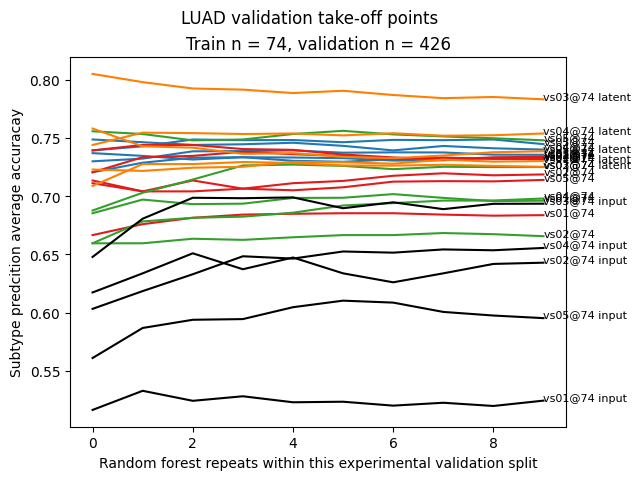

In [401]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
    plt.annotate(run, (9, inpt_val[run][9]),
                  fontsize = 8,
                  # ha = 'center'
                 )
for run in lat_val.columns:
    plt.plot(lat_val[run], color = plt.cm.Paired(5), label = run)
    plt.annotate(run, (9, lat_val[run][9]), fontsize = 8)    
for run in dec_val.columns:
    plt.plot(dec_val[run], color = plt.cm.Paired(3), label = run)
    plt.annotate(run, (9, dec_val[run][9]), fontsize = 8)
for run in synth_lat_val.columns:
    plt.plot(synth_lat_val[run], color = plt.cm.Paired(7), label = run)
    plt.annotate(run+' latent', (9, synth_lat_val[run][9]), fontsize = 8)
for run in synth_inpt_val.columns:
    plt.plot(synth_inpt_val[run], color = 'black', label = run)    
    plt.annotate(run+' input', (9, synth_inpt_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' validation take-off points')
plt.title('Train n = '+str(
    len(trn))+', validation n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
# plt.legend()
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input+latent+decoded+synthLat+synthInp_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

In [323]:
synth_lat_val

,vs03@74,vs02@74,vs01@74
0,0.805164,0.708920,0.723005
1,0.798122,0.727700,0.721831
2,0.792645,0.727700,0.724570
3,0.791667,0.729460,0.725352
4,0.788732,0.728638,0.729577
5,0.790689,0.726526,0.729264
6,0.787056,0.726358,0.728035
7,0.784331,0.727113,0.731514
8,0.785342,0.726135,0.729786
9,0.783333,0.725352,0.730282


## L. curve

In [140]:
resmpl_count = 30

In [87]:
resmpl_count

30

In [ ]:
# Operating instructions:
    # Toggle-in each of four objects to the dataframe-to-classify variable
        # Toggle the sample count floor / ceiling in the function - in/dec vs synth.lat/synth.in
        # saving the accrcy frm into a unique object each time
    # Run seperate box production functions for the latent production
        # Sixth object - blend, replace with dashed blue and orange lines

In [402]:
df_to_clf = trn # Check ceilings
d_phs = 'input'
toggle_check = 'input done'
curve_range = list(range(10, trn_size+1, 5))

In [405]:
df_to_clf = decoded_labeled
d_phs = 'decoded'
toggle_check = 'decoded done'
curve_range = list(range(10, trn_size+1, 5))

In [408]:
upper_step = 30
outer_limits = 501        # Look at this <---------
df_to_clf = synth_lat_dec
d_phs = 'lat_synth'
toggle_check = 'synthetic from latent done'
curve_range = list(range(trn_size, outer_limits, upper_step))

In [411]:
df_to_clf = synth_input_decoded # upper_step and outer_limits recycled
d_phs = 'inpt_synth'
toggle_check = 'synthetic from input done'
curve_range = list(range(trn_size, outer_limits, upper_step))

In [412]:
# Line_curve_frame, for four inputs
accuracy_curve_frame = pd.DataFrame() # to concat, with the latent and blend
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]
print(d_phs+' start')
for smp_sz in curve_range: # this is important, toggle above

    step_frame = pd.DataFrame()
    print(smp_sz)

    RF_output = []
    for r in list(range(0, resmpl_count)): # 30 resamplings at each step size
        
        labeled_sample_subset_frame = df_to_clf.sample(smp_sz) # df_to_clf toggle
        X_trn = labeled_sample_subset_frame.iloc[:, 1:]
        y_trn = labeled_sample_subset_frame.iloc[:, 0]

        clf_trn = RandomForestClassifier()
        clf_trn.fit(X_trn, y_trn)
        
        raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))

        RF_output.append(raw_acc)
    
    step_frame['data_phase'] = [d_phs] * resmpl_count # <--- data phase variable from toggle
    
    step_frame['step_size'] = [smp_sz] * resmpl_count
    step_frame['Accuracy'] = RF_output
    accuracy_curve_frame = pd.concat( [accuracy_curve_frame, step_frame] , axis = 0)    
    
print(toggle_check) # tog check

inpt_synth start
74
104
134
164
194
224
254
284
314
344
374
404
434
464
494
synthetic from input done


In [404]:
input_bx_crv = accuracy_curve_frame

In [407]:
decoded_bx_crv = accuracy_curve_frame

In [410]:
lat_synth_bx_crv = accuracy_curve_frame

In [413]:
inpt_synth_bx_crv = accuracy_curve_frame

## Check out

In [414]:
input_bx_crv.head(1)

,data_phase,step_size,Accuracy
0,input,10,0.359155


In [415]:
decoded_bx_crv.head(1)

,data_phase,step_size,Accuracy
0,decoded,10,0.464789


In [416]:
lat_synth_bx_crv.head(1)

,data_phase,step_size,Accuracy
0,lat_synth,74,0.619718


In [417]:
inpt_synth_bx_crv.head(1) # Could add replicates tag as column or direct to label (?) - after big concat

,data_phase,step_size,Accuracy
0,inpt_synth,74,0.58216


## Latent Learning curve  
This takes the encoded validation

In [418]:
# Red latent curve box_curve_frame, no variable toggles
d_phs = 'latent'
toggle_check = 'latent done'
accuracy_curve_frame = pd.DataFrame() # to concat zone
X_val = val_encoded_labeled.iloc[:, 1:]
y_val = val_encoded_labeled.iloc[:, 0]
for smp_sz in list(range(10, trn_size+1, 5)): # Curve range
    step_frame = pd.DataFrame()
    print(smp_sz)

    RF_output = []
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = latent_object.sample(smp_sz) # df_to_clf direct set as latent object
        X_trn = labeled_sample_subset_frame.iloc[:, 1:]
        y_trn = labeled_sample_subset_frame.iloc[:, 0]

        clf_trn = RandomForestClassifier()
        clf_trn.fit(X_trn, y_trn)
        
        raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))

        RF_output.append(raw_acc)
    
    step_frame['data_phase'] = [d_phs] * resmpl_count
    
    step_frame['step_size'] = [smp_sz] * resmpl_count
    step_frame['Accuracy'] = RF_output
    accuracy_curve_frame = pd.concat( [accuracy_curve_frame, step_frame] , axis = 0)    
latent_bx_crv = accuracy_curve_frame    
print(toggle_check)

10
15
20
25
30
35
40
45
50
55
60
65
70
latent done


In [278]:
latent_bx_crv.head(1)

,data_phase,step_size,Accuracy
0,latent,10,0.36385


## Blend zone

In [302]:
# Blend the synth-from-latent with the input

In [279]:
trn.shape

(74, 5001)

In [221]:
synth_lat_dec.shape # 100 synth-from-latent samples per subtype

(500, 5001)

In [419]:
blend_to_clf = pd.concat([trn, synth_lat_dec],
                        axis = 0)
blend_to_clf.shape

(574, 5001)

In [420]:
# Blend predictions, to box curve
d_phs = 'blend_inp/synth.frm.ltnt' # tog 1
toggle_check = 'blender done'      # 2
accuracy_curve_frame = pd.DataFrame() # to concat zone
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]
print(d_phs+' start')
print('step size is '+str(upper_step))
for smp_sz in list(range(trn_size, outer_limits, upper_step)): # This is curve_range earlier 3
    step_frame = pd.DataFrame()
    print(smp_sz)

    RF_output = []
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = blend_to_clf.sample(smp_sz) # df_to_clf MANUAL TOGGLE function 4
        X_trn = labeled_sample_subset_frame.iloc[:, 1:]
        y_trn = labeled_sample_subset_frame.iloc[:, 0]

        clf_trn = RandomForestClassifier()
        clf_trn.fit(X_trn, y_trn)
        
        raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))

        RF_output.append(raw_acc)
    
    step_frame['data_phase'] = [d_phs] * resmpl_count
    
    step_frame['step_size'] = [smp_sz] * resmpl_count
    step_frame['Accuracy'] = RF_output
    accuracy_curve_frame = pd.concat( [accuracy_curve_frame, step_frame] , axis = 0)    
blend1_bx_crv = accuracy_curve_frame    
print(toggle_check)

blend_inp/synth.frm.ltnt start
step size is 30
74
104
134
164
194
224
254
284
314
344
374
404
434
464
494
blender done


## Line curve

In [421]:
box_curve_frame = pd.concat(
    [input_bx_crv,
     latent_bx_crv,
     decoded_bx_crv,
     
     lat_synth_bx_crv,
     inpt_synth_bx_crv,
    blend1_bx_crv] ,
    axis = 0)

In [225]:
box_curve_frame.data_phase.unique()

array(['input', 'latent', 'decoded', 'lat_synth', 'inpt_synth',
       'blend_inp/synth.frm.ltnt'], dtype=object)

In [333]:
lat_syn_chk = box_curve_frame[box_curve_frame.data_phase == 'lat_synth']

In [337]:
mean(lat_syn_chk[lat_syn_chk.step_size == 494].Accuracy)

0.7830203442879499

In [339]:
mean(synth_lat_val['vs03@74'])

0.7907080445636784

In [ ]:
# Add max input (blue) dashed line and value annotation
# Add max synthetic value annotation and line 

In [423]:
box_curve_frame # ADD a replicate column, overlay line curves

,data_phase,step_size,Accuracy
0,input,10,0.359155
1,input,10,0.551643
2,input,10,0.363850
3,input,10,0.392019
4,input,10,0.523474
...,...,...,...
25,blend_inp/synth.frm.ltnt,494,0.765258
26,blend_inp/synth.frm.ltnt,494,0.776995
27,blend_inp/synth.frm.ltnt,494,0.784038
28,blend_inp/synth.frm.ltnt,494,0.769953


/var/folders/5v/88tvwqd94gs4dfr3h6rt1_w0qd13bg/T/ipykernel_23877/355147433.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=-55,


vs05@74 done


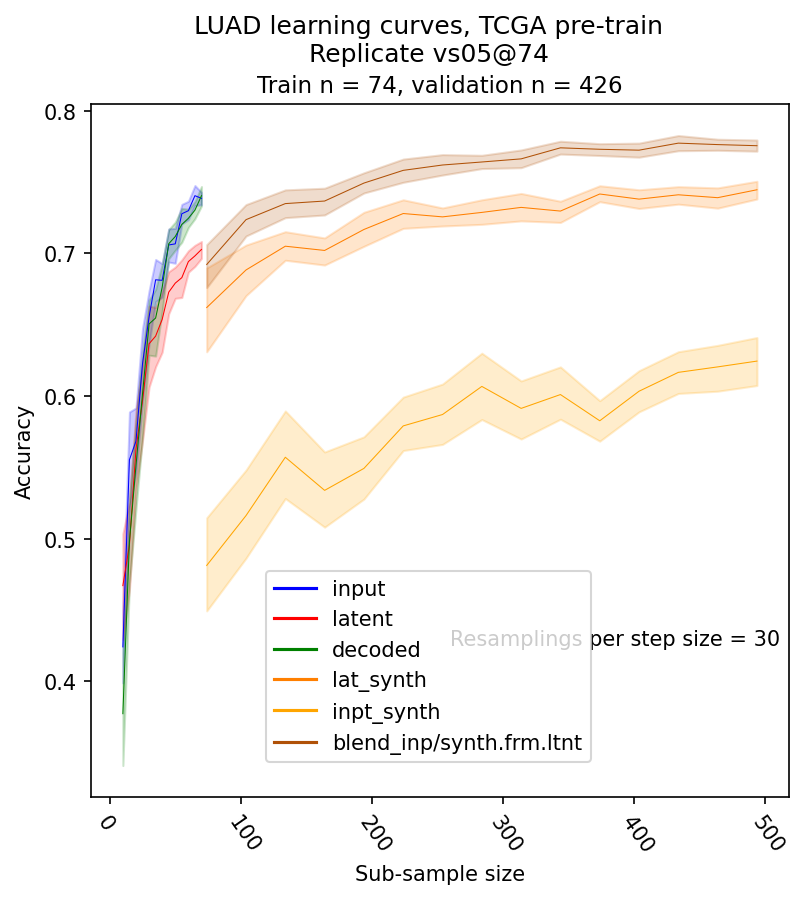

In [422]:
# Blended box curve
figure(figsize=(6, 6), dpi=150)
palette=['blue', 'red','green',
         plt.cm.Paired(7), 'orange', '#b05107']

phase_list = ['input', 'latent', 'decoded',
              'lat_synth', 'inpt_synth', 'blend_inp/synth.frm.ltnt']

ax = sns.lineplot(x='step_size', y='Accuracy',
            hue='data_phase', palette=palette,
            data=box_curve_frame, linewidth = .5)
    
plt.suptitle(trn.index.name+' learning curves, '+'TCGA pre-train'+
            '\nReplicate '+val_split)
plt.title('Train n = '+str(len(trn))+', validation n = '+str(len(val)), fontsize = 11) # across or within cohorts
plt.ylabel('Accuracy')
plt.xlabel('Sub-sample size')
plt.annotate('Resamplings per step size = '+str(resmpl_count),
                xy=(.5, .3), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )
plt.legend(loc=(.25,.05))
ax.set_xticklabels(ax.get_xticklabels(),rotation=-55,
                   ha='left',
                   rotation_mode='anchor'
                  )
plt.savefig(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/learn_curve/'+fine_tune_file.index.name+'_learning_curve_with_TCGA_pretrain_'+str(
    repeats)+'_'+val_split+'_line.png', bbox_inches = 'tight')
print(val_split+' done')

In [227]:
# Write the line_box plot object to disk
    # Straight into the line curve dir

box_curve_frame.to_csv(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/learn_curve/fit.'+fit_on+'_epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+str(pre_train_epochs)+
    '_line_curve.'+str(latent_dim)+
    '_'+feature_set+'_'+val_split+
    '.tsv',
    sep = '\t')

In [170]:
ls i_o/rep_0.7/LUAD/learn_curve/*

i_o/rep_0.7/LUAD/learn_curve/LUAD_learning_curve_with_TCGA_pretrain_10_vs01@50_line.png
i_o/rep_0.7/LUAD/learn_curve/fit.LUAD_epochs.200_pre_trained_on.TCGA_n_7509_epochs.5_line_curve.500_mad_5k_across_vs01@50.tsv


In [228]:
v

'rep_0.7'

In [229]:
fine_tune_file.index.name

'LUAD'

In [230]:
val_split

'vs01@74'

## bx crv tmplt

In [ ]:
ax = sns.boxplot(x='step_size', y='Accuracy',
            hue='data_phase', palette=palette,
            data=box_curve_frame, linewidth = .5)

## bx crv archive

In [ ]:
# for pal_idx, phase in enumerate(phase_list):
#     phase_frame = box_curve_frame[box_curve_frame.data_phase == phase]
#     mean_list = []
#     step_list = []
#     for step_size in phase_frame.step_size.unique():
#         mean_list.append(mean(phase_frame[phase_frame.step_size == step_size].Accuracy))
#         step_list.append(step_size)
#     sns.plot(step_list, mean_list, color = palette[pal_idx])

In [ ]:
box_curve_frame = pd.concat(
    [input_bx_crv,
     decoded_bx_crv,
     lat_synth_bx_crv,
     inpt_synth_bx_crv] , axis = 0)

In [80]:
box_curve_frame.data_phase.unique()#tmplt

array(['input', 'decoded', 'lat_synth', 'inpt_synth'], dtype=object)

In [66]:
box_curve_frame

,data_phase,step_size,Accuracy
0,input,10,0.596774
1,input,10,0.493548
2,input,10,0.705376
3,input,10,0.537634
4,input,10,0.551613
...,...,...,...
30,inpt_synth,150,0.544086
31,inpt_synth,150,0.541935
32,inpt_synth,150,0.577419
33,inpt_synth,150,0.543011


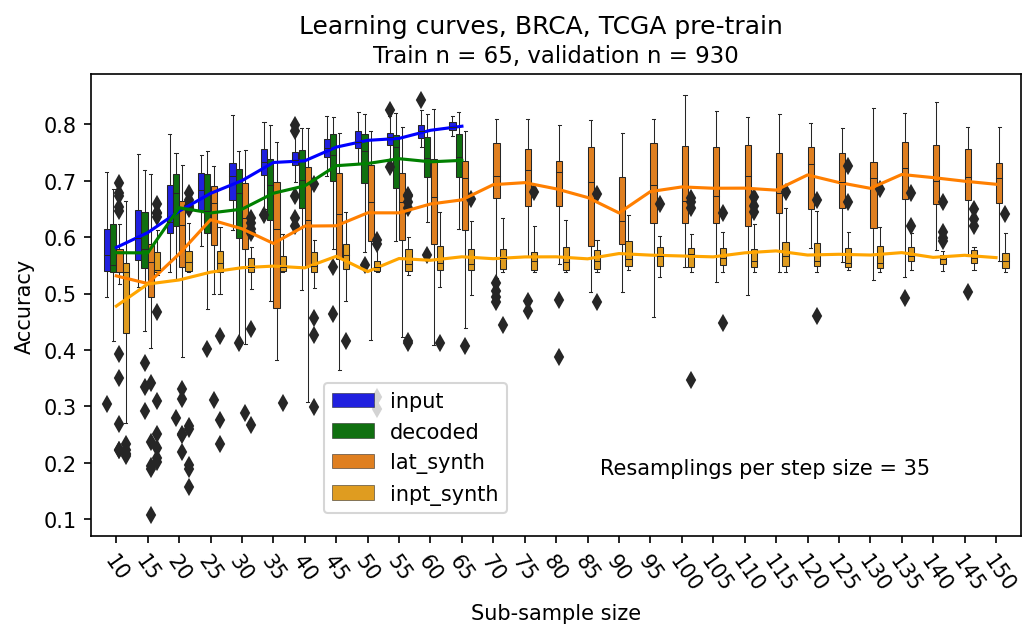

In [67]:
# Box curve, hue on data_phase column (TEMPLATE)
figure(figsize=(6, 6), dpi=150)
palette=['blue','green', plt.cm.Paired(7), 'orange']
ax = sns.boxplot(x='step_size', y='Accuracy',
            hue='data_phase', palette=palette,
            data=box_curve_frame, linewidth = .5)
phase_list = ['input', 'decoded', 'lat_synth', 'inpt_synth']

for pal_idx, phase in enumerate(phase_list):
    phase_frame = box_curve_frame[box_curve_frame.data_phase == phase]
    mean_list = []
    for step_size in phase_frame.step_size.unique():
        mean_list.append(mean(phase_frame[phase_frame.step_size == step_size].Accuracy))
        
    plt.plot(mean_list, color = palette[pal_idx])
plt.suptitle('Learning curves, '+trn.index.name+', TCGA pre-train')
plt.title('Train n = '+str(len(trn))+', validation n = '+str(len(val)), fontsize = 11) # across or within cohorts
plt.ylabel('Accuracy')
plt.xlabel('Sub-sample size')
plt.annotate('Resamplings per step size = '+str(resmpl_count),
                xy=(.5, .3), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )
plt.legend(loc=(.25,.05))
ax.set_xticklabels(ax.get_xticklabels(),rotation=-55,
                   ha='left',
                   rotation_mode='anchor'
                  )
plt.savefig(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/learn_curve/'+fine_tune_file.index.name+'_learning_curve_with_TCGA_pretrain_'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

In [ ]:
plt.annotate('Synthetic data ratio: 200%',
                xy=(.45, .35), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )

## Front-end box

In [425]:
inpt_summ = pd.DataFrame(data = inpt_val.iloc[9,:])
inpt_summ.insert(0, 'Take-off_point', 'input')

In [432]:
lat_summ = pd.DataFrame(data = lat_val.iloc[9,:])
lat_summ.insert(0, 'Take-off_point', 'latent')

In [427]:
dec_summ = pd.DataFrame(data = dec_val.iloc[9,:])
dec_summ.insert(0, 'Take-off_point', 'decoded')

In [428]:
syn_lat_summ = pd.DataFrame(data = synth_lat_val.iloc[9,:])
syn_lat_summ.insert(0, 'Take-off_point', 'latent_synth')

In [429]:
syn_inpt_summ = pd.DataFrame(data = synth_inpt_val.iloc[9,:])
syn_inpt_summ.insert(0, 'Take-off_point', 'input_synth')

In [433]:
summ = pd.concat([inpt_summ, lat_summ, dec_summ, syn_lat_summ, syn_inpt_summ])

In [ ]:
summ = pd.concat([inpt_summ, dec_summ, syn_lat_summ, syn_inpt_summ])

In [194]:
summ

,Take-off_point,9
vs04,input,0.979496
vs03,input,0.969424
vs02,input,0.970504
vs01,input,0.959712
vs00,input,0.970144
vs04,decoded,0.976259
vs03,decoded,0.970504
vs02,decoded,0.973381
vs01,decoded,0.960072
vs00,decoded,0.967626


In [434]:
summ

,Take-off_point,9
vs05@74,input,0.744836
vs04@74,input,0.740141
vs03@74,input,0.735681
vs02@74,input,0.731690
vs01@74,input,0.734272
vs05@74,latent,0.714085
vs04@74,latent,0.732160
vs03@74,latent,0.733803
vs02@74,latent,0.718779
vs01@74,latent,0.683803


In [ ]:
Basically need to add a front-end cell for RF on the blend, prior to the Learning Curve

In [435]:
summ.columns = ['Take-off_point', 'Accuracy']

In [ ]:
# Plot the front-end model performance
# This is how to gauge the quality of the input to the learning curve

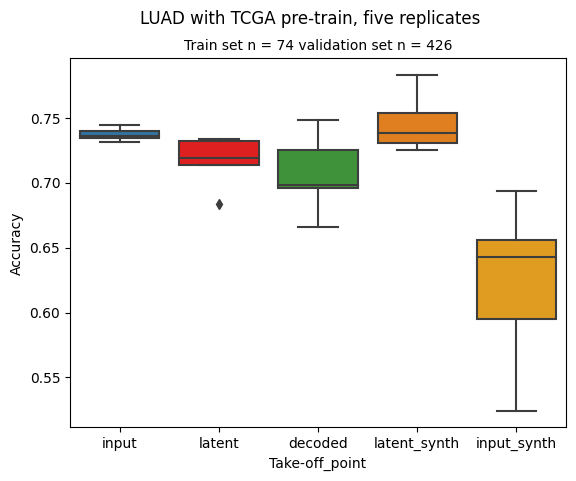

In [438]:
my_pal = {'input': plt.cm.Paired(1),
          'latent': 'red',
          'decoded': plt.cm.Paired(3), 
          'latent_synth': plt.cm.Paired(7),
          'input_synth': 'orange'}

# figure(figsize=(8, 4), dpi=150)
ax = sns.boxplot(summ, x='Take-off_point', y='Accuracy',
           palette = my_pal)

# add_stat_annotation(ax,
#                     data=summ,
#                     x='Take-off_point',
#                     y='Accuracy',
#                     # order=order,
#                     box_pairs=[('input', 'decoded'),
#                               ('input', 'latent_synth'),
#                               ('input', 'input_synth')
#                               ],
#                     test='Mann-Whitney', text_format='star', loc='outside', verbose=0)

plt.suptitle(trn.index.name+' with TCGA pre-train, five replicates')
plt.title('Train set n = '+str(len(trn))+' validation set n = '+str(len(val)),
         fontsize = 10)
plt.savefig('i_o/'+v+'/'+trn.index.name+'_front_end_direct_'+str(
    repeats)+'_'+val_split+'_repeats.png', bbox_inches = 'tight')